<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [258]:
%autosave 30

Autosaving every 30 seconds


In [259]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time

from tqdm import tqdm

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, make_scorer, classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, recall_score, precision_score,f1_score, mean_squared_error
from sklearn.model_selection import train_test_split,  TimeSeriesSplit, cross_val_predict,cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

In [260]:
taxi_df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [261]:
taxi_df.sort_index(inplace=True)
taxi_df = taxi_df.resample('1H').sum()


In [262]:
taxi_df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Анализ

In [263]:
def explore_data(df):
    display(
        "Сводная информация:", df.info(),
        "10 строк:", df.head(10),
        "Столбцы:", df.columns,
        "Числовое описание:", df.describe(),
        "Сумма пропусков:", df.isna().sum(),
        "Доля пропусков:", df.isna().mean(),
        #"Явные дубликаты:", df.duplicated().sum(),
        #"Корреляция:", df.corr(),
       # sns.heatmap(df.corr())
    )

In [264]:
explore_data(taxi_df)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


'Сводная информация:'

None

'10 строк:'

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


'Столбцы:'

Index(['num_orders'], dtype='object')

'Числовое описание:'

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


'Сумма пропусков:'

num_orders    0
dtype: int64

'Доля пропусков:'

num_orders    0.0
dtype: float64

проверим, в хронологическом ли порядке расположены даты и время. Для этого
нужно посмотреть атрибут индекса таблицы is_monotonic. Если порядок
соблюдён, атрибут вернёт True, если нет — False

In [265]:
taxi_df.index.is_monotonic


True

<AxesSubplot:xlabel='datetime'>

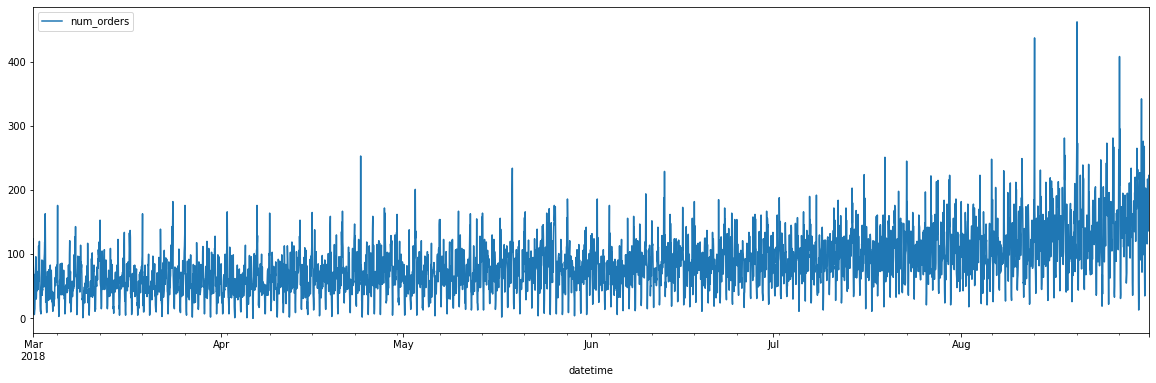

In [266]:
taxi_df.plot(figsize=(20,6))

In [267]:
decomposed = seasonal_decompose(taxi_df)

<AxesSubplot:title={'center':'Trend'}, xlabel='datetime'>

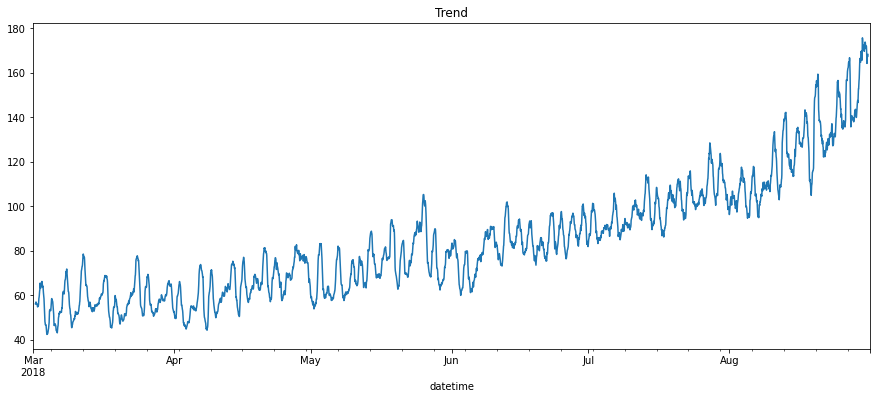

In [268]:
decomposed.trend.plot(ax=plt.gca(), title='Trend', figsize=(15,6))

Наблюдается явный тренд => ряд не стационарен

<AxesSubplot:title={'center':'Seasonality'}, xlabel='datetime'>

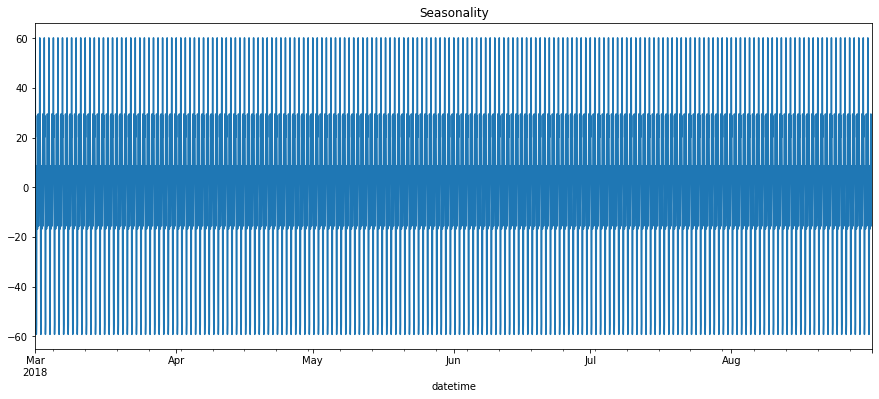

In [269]:
decomposed.seasonal.plot(ax=plt.gca(), title='Seasonality',figsize=(15,6))

<AxesSubplot:title={'center':'Week Seasonality'}, xlabel='datetime'>

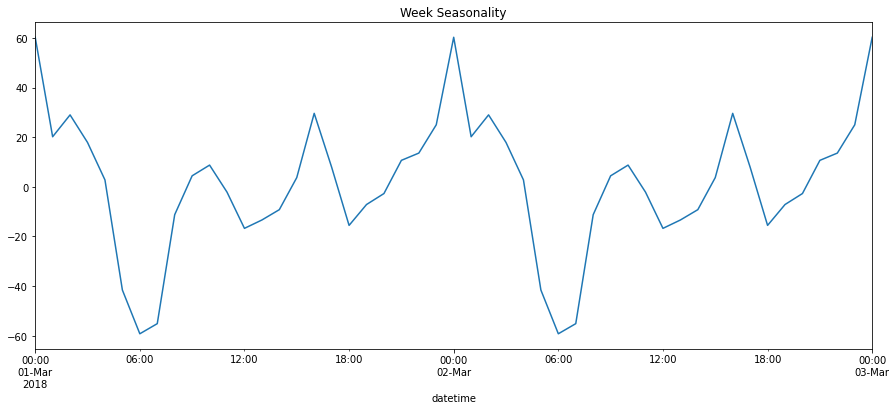

In [270]:
#test = taxi_df.resample('1H').sum()
decomposed.seasonal['2018-03-01 00:00:00':'2018-03-03 00:00:00'].plot(ax=plt.gca(), title='Week Seasonality',figsize=(15,6))
#seasonal_decompose(test['2018-03-01 00:00:00':'2018-03-03 00:00:00']).seasonal.plot(ax=plt.gca(), title='Week Seasonality',figsize=(15,6))

Если рассмотреть сезонность в разрезе двух днней, то становиться очевидно, что пик заказов приходится на полночь, а минимум на 6 утра

<AxesSubplot:title={'center':'Residuals'}, xlabel='datetime'>

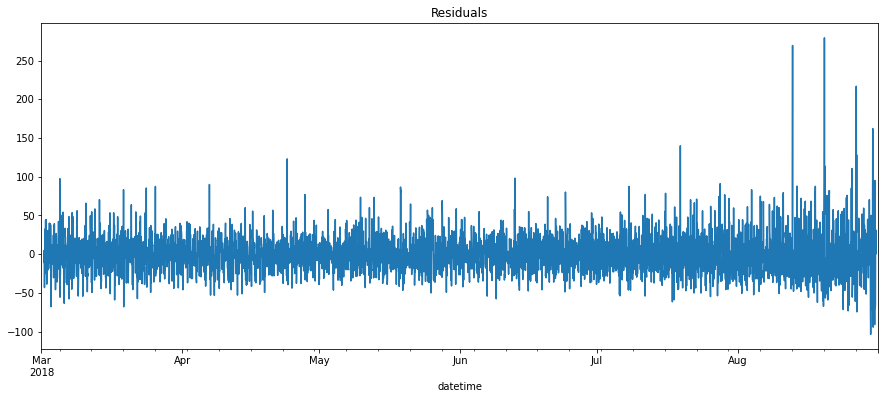

In [271]:
decomposed.resid.plot(ax=plt.gca(), title='Residuals', figsize=(15,6))

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ Полезно запомнить</b></u></p>
    <p>
Исследование - понятно.<br>
Инструмент декомпозиции в частности, а графический анализ временных рядов как в принципе - важный этап моделирования рядов.<br> Позволяет увидеть продажи визуально, а это помогает сделать предвариетльные выводы<br>
    
В реальности бизнеса есть все три вида сезонности:<br>
1) дневная сезонность -  данные собраны по дням, т.е. будни и выходные имеют разные продажи<br>
2) внутрисуточная сезонность: когда продажи утром отличаются от продаж вечером <br>
3) месячная сезонность: когда продажи лета и осени - разные.<br><br>
И если строить прогноз на длительный период времени, то без учёта всех видов сезонности  - не обойтись<br>
Например: есть в данных восходящий тренд. Но вопрос такой возникает: <br>
этот подъём действительно за счёт роста компании (чаще всего тренд - это отражение роста компании) или есть ещё влияние месячной сезнности? (летом - продаж в рост, например, и именно этот момент мы наблюдаем в данных)<br>
Ответ на вопрос - не протой на имеющихся данных - у нас данных меньше года. А это означает, что месячную сезонность нам не просто вычислить адекватно - т.е. не внести в модель корректтировки месяцев(<br>

на горизонте прогнозирования - несколько часов или дней - можно предположить что у нас тренд.<br>
А если строить прогноз на несколько недель - вот тут утверждать наличие тренда надо с большой осторожностью))))<br><br>

</font></p></div>

## Обучение

Напишем функцию для добавления данных

In [272]:
def make_features(data, max_lag, rolling_mean_size):
    #data['year'] = data.index.year
    #data['month'] = data.index.month
    #data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()# < напишите код здесь >


<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ Полезно запомнить</b></u></p> Сразу пару строк о факторе месяц:<br>
Если нам брать горизонт прогноза месяц или два , то фактор месяц - очень важне  это факт. А если брать горизонт прогноза несколько часов, то фактор времени года - на таком отрезке времени и не заметен. К тому же, он уже присутствует в тренде (скользящем среднем). Т.е. его участие локально как бы и есть.<br>

То, что сейчас месяц может увеличивать точность - это случайно. Он ведь представлен как числа от 1 до 8 и ещё есть тренд, как раз. Т.е. произошло наложение тренда и номера месяца. А вот если продажи буду уходить вниз (или перестанут расти), а мы будем продолжать пользовться моделью, то модель будет предсказывать рост на сентябрь (цифра 9), на октябпрь (цифра 10)... т.е. чиссто числовая тенденция)<br>
    
Поэтому, рекомендация для будущих проетов на эту тему:<br>
Учитывать горизонт прогноза: если задача стоит среднесрочного и долгосрочного прогноза, то месяц нам в помощь (при этом данных должно быть не меннее 2-х / 3-х лет). Если задача краткосрочного прогнозирования - месяц не надо использовать, он уже в тренде заложен.</div>

In [273]:
make_features(taxi_df, 24, 24)

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ Полезно запомнить</b></u></p>Пару строк по фактору лаг и скользящее среднее:<br>
Lag: его называют ещё параметром авторегрессии. На бытовом уровне его можно понять так: допустим вчера мы собрались с друзьями и не много закусили.... повлияет ли это на сегодняшний настрой на жизнь? Скорее да)))) Так вот с авторегрессией также. Допустим lag=1 - учитывает (для удобства будем считать, что продажи собраны по дням) как вчерашние продажи - вчерашние события - воалияли на сегоняшние.Lag=2: учитывает как позавчерашние продажи влияютна сегодняшние.....<br>
    
По скользящему среднего:<br>
Предположим rolling=10 - скользящее среднее. По сути, ищем среднее по 10 точкам, потом следующие 10 точек, и т.д. - это некое подобие тренда будет - средней линии. Т.е. - сглаживание колебаний/выбросов. Это легко увидеть на пределе: допустим длина ряда 100 дней. rolling(100) - это просто одно число - среднее всего ряда. <br>
    
Поэтому, если выставить сезонности - hour и деньНедели, то дополнительные факторы могут быть такие: лаг =1 (максимум 2), а скользящее среднее = 24 (среднее за сутки). Т.е. начинать с этого. В итоге модель будет приемлемая по точности и не много факторов.. а это значит и для бизнеса будет легче доносить решение)</div>

удалим пропуски

In [274]:
taxi_df = taxi_df.dropna()
taxi_df.head()

,num_orders,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,4,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,56.833333
2018-03-02 01:00:00,120,4,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,55.416667
2018-03-02 02:00:00,75,4,120.0,90.0,58.0,113.0,66.0,61.0,45.0,73.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,56.875000
2018-03-02 03:00:00,64,4,75.0,120.0,90.0,58.0,113.0,66.0,61.0,45.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,57.041667
2018-03-02 04:00:00,20,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,61.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,56.958333


Разделим данные на выборки

In [275]:
train, test = train_test_split(taxi_df, test_size=0.1,shuffle=False, random_state=12345)

In [276]:
features_train = train.drop('num_orders', axis=1)
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']
target_train = train['num_orders']

In [277]:
print('train min: ',train.index.min(),'train max: ', train.index.max())
print('test min: ',test.index.min(),'test max: ', test.index.max())

train min:  2018-03-02 00:00:00 train max:  2018-08-13 15:00:00
test min:  2018-08-13 16:00:00 test max:  2018-08-31 23:00:00


Приведем данные к одинаковому масштабу

In [278]:
scaler = StandardScaler()
scaler.fit(features_train[:])
features_train[:] = scaler.transform(features_train[:])
features_test[:] = scaler.transform(features_test[:])

Чтобы ускорить обработку, кменьшим размер данных до 'float16'

In [279]:
features_train = features_train.astype('float16')

Создадим функцию для вычисления метрики rmse и функцию для подбора гиперпараметров

In [280]:
def rmse(predictions, target):
    return mean_squared_error(predictions, target, squared= False)
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [281]:
def best_hypers_for_model(model, hyperparams, scorer):
    
    ts_cv = TimeSeriesSplit(n_splits=8).split(features_train)
    clf = GridSearchCV(model, hyperparams, scoring=scorer, cv=ts_cv)
    clf.fit(features_train, target_train)
    print(str(model)[:-2],"Best parameters set found on development set:\n")
    print(clf.best_params_)
    print("\nGrid scores on development set:\n")
    for mean, std, params in zip(clf.cv_results_['mean_test_score'], clf.cv_results_['std_test_score'], clf.cv_results_['params']):
        print("%0.6f for %r"% (abs(mean), params))

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ Полезно запомнить</b></u></p>
n_splits , обычно, задают так, чтобы размер валидационной выборки при проведении кросс-валидации примерно совпадал с размером тестовой выборки. Размер тестовой выборки у нас 10%, а размер валидационной равен 1/(n_splits+1) части от обучающей выборки (см. документацию к TimeSeriesSplit). К примеру, если n_splits=2, то размер валидационной равен 1/3 от обучающей выборки, т.е. 1/3*90%=30% от исходной выборки.<br>
Возможно, что n_splits=8, то 1/9*90%=10%  - будет более точное попадание.
</div>

In [282]:
def best_model_result(model_dict):
    
    predictions_dict = {}
    for model_name in tqdm(model_dict):
        l_start = time.time()
        model = model_dict[model_name]
        model.fit(features_train, target_train)
        l_end = time.time()
        result.loc[model_name, "learning_time"] = l_end - l_start
        p_start = time.time()
        predictions = model.predict(features_test)
        predictions_dict[model_name] = predictions
        p_end = time.time()
        result.loc[model_name, "predict_time"] = p_end - p_start
        result.loc[model_name, "RMSE"] = rmse(predictions, target_test)
    return predictions_dict

In [283]:
MODEL_SETTINGS = {'max_depth':[x for x in range(2, 21)],
                  'random_state':[12345]}
best_hypers_for_model(DecisionTreeRegressor(),MODEL_SETTINGS,rmse_scorer)

DecisionTreeRegressor Best parameters set found on development set:

{'max_depth': 4, 'random_state': 12345}

Grid scores on development set:

31.515680 for {'max_depth': 2, 'random_state': 12345}
30.336049 for {'max_depth': 3, 'random_state': 12345}
29.996264 for {'max_depth': 4, 'random_state': 12345}
30.449601 for {'max_depth': 5, 'random_state': 12345}
30.289131 for {'max_depth': 6, 'random_state': 12345}
31.265939 for {'max_depth': 7, 'random_state': 12345}
31.816113 for {'max_depth': 8, 'random_state': 12345}
32.043484 for {'max_depth': 9, 'random_state': 12345}
32.838947 for {'max_depth': 10, 'random_state': 12345}
33.774481 for {'max_depth': 11, 'random_state': 12345}
34.658854 for {'max_depth': 12, 'random_state': 12345}
34.966941 for {'max_depth': 13, 'random_state': 12345}
34.846995 for {'max_depth': 14, 'random_state': 12345}
34.919034 for {'max_depth': 15, 'random_state': 12345}
35.119037 for {'max_depth': 16, 'random_state': 12345}
34.471934 for {'max_depth': 17, 'random_

In [284]:
MODEL_SETTINGS = {'max_depth':[x for x in range(2, 21)],
                  'n_estimators': [x for x in range (10, 51, 10)],
                  'random_state':[12345]}
best_hypers_for_model(RandomForestRegressor(),MODEL_SETTINGS,rmse_scorer)


RandomForestRegressor Best parameters set found on development set:

{'max_depth': 18, 'n_estimators': 50, 'random_state': 12345}

Grid scores on development set:

30.494489 for {'max_depth': 2, 'n_estimators': 10, 'random_state': 12345}
30.253192 for {'max_depth': 2, 'n_estimators': 20, 'random_state': 12345}
30.278056 for {'max_depth': 2, 'n_estimators': 30, 'random_state': 12345}
30.223417 for {'max_depth': 2, 'n_estimators': 40, 'random_state': 12345}
30.260228 for {'max_depth': 2, 'n_estimators': 50, 'random_state': 12345}
29.077289 for {'max_depth': 3, 'n_estimators': 10, 'random_state': 12345}
28.849238 for {'max_depth': 3, 'n_estimators': 20, 'random_state': 12345}
28.792015 for {'max_depth': 3, 'n_estimators': 30, 'random_state': 12345}
28.803705 for {'max_depth': 3, 'n_estimators': 40, 'random_state': 12345}
28.780338 for {'max_depth': 3, 'n_estimators': 50, 'random_state': 12345}
28.083162 for {'max_depth': 4, 'n_estimators': 10, 'random_state': 12345}
27.881027 for {'max_de

In [285]:
MODEL_SETTINGS = {
  'learning_rate': [0.1, 0.5, 0.8],
  'n_estimators': [x for x in range (10, 51, 10)],
  'max_depth': [x for x in range (2,20)]}
                
best_hypers_for_model(GradientBoostingRegressor(),MODEL_SETTINGS,rmse_scorer)

GradientBoostingRegressor Best parameters set found on development set:

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}

Grid scores on development set:

31.478519 for {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 10}
28.754943 for {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 20}
27.603646 for {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 30}
26.915852 for {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 40}
26.538626 for {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50}
30.751767 for {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 10}
27.861805 for {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 20}
26.680879 for {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 30}
26.092341 for {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 40}
25.782129 for {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
30.151518 for {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 10}
27.354124 for {'learning_rate':

In [286]:
MODEL_SETTINGS = {
  'verbose':[False],
  'learning_rate': [0.1, 0.5, 0.8],
  'iterations': [2,3,5],
  'max_depth': [x for x in range (2,20)]}
best_hypers_for_model(CatBoostRegressor(),MODEL_SETTINGS,rmse_scorer)

<catboost.core.CatBoostRegressor object at 0x7ff01c2ce0d Best parameters set found on development set:

{'iterations': 5, 'learning_rate': 0.8, 'max_depth': 7, 'verbose': False}

Grid scores on development set:

37.632065 for {'iterations': 2, 'learning_rate': 0.1, 'max_depth': 2, 'verbose': False}
37.175841 for {'iterations': 2, 'learning_rate': 0.1, 'max_depth': 3, 'verbose': False}
37.195593 for {'iterations': 2, 'learning_rate': 0.1, 'max_depth': 4, 'verbose': False}
37.056844 for {'iterations': 2, 'learning_rate': 0.1, 'max_depth': 5, 'verbose': False}
36.996301 for {'iterations': 2, 'learning_rate': 0.1, 'max_depth': 6, 'verbose': False}
36.954505 for {'iterations': 2, 'learning_rate': 0.1, 'max_depth': 7, 'verbose': False}
37.065022 for {'iterations': 2, 'learning_rate': 0.1, 'max_depth': 8, 'verbose': False}
37.102839 for {'iterations': 2, 'learning_rate': 0.1, 'max_depth': 9, 'verbose': False}
37.216403 for {'iterations': 2, 'learning_rate': 0.1, 'max_depth': 10, 'verbose': Fa

## Тестирование

Обучим модели с наилучшими гиперпараметрами и протестируем на тестовой выборке

In [287]:
result = pd.DataFrame(index=["RandomForestRegressor","DecisionTreeRegressor", "CatBoostRegressor",'GradientBoostingRegressor'],
                      columns=["RMSE", "learning_time", "predict_time"])

In [288]:
predictions = best_model_result({'DecisionTreeRegressor': DecisionTreeRegressor(max_depth=4, random_state=12345),
                   'RandomForestRegressor': RandomForestRegressor(max_depth=18, n_estimators=50, random_state=12345),
                   'CatBoostRegressor': CatBoostRegressor(iterations=5, learning_rate=0.8, max_depth=7, verbose=False),
                    'GradientBoostingRegressor': GradientBoostingRegressor(learning_rate=0.1, max_depth=5, n_estimators=50),
                  'LGBMRegressor': LGBMRegressor(learning_rate=0.8, max_depth=9, n_estimators=9, random_state=12345)})


100%|██████████| 5/5 [00:25<00:00,  5.15s/it]


## Вывод

Из выбранных моделей по качеству прошла лишь RandomForestRegressor с RMSE = 43.598593
GradientBoostingRegressor	RMSE = 44.655158

In [289]:
result

,RMSE,learning_time,predict_time
RandomForestRegressor,43.598593,2.112091,0.008084
DecisionTreeRegressor,55.196511,0.021849,0.00227
CatBoostRegressor,49.805385,0.221075,0.00189
GradientBoostingRegressor,44.655158,1.078559,0.0021
LGBMRegressor,49.015661,22.26597,0.008286


<AxesSubplot:title={'center':'результат модели RandomForestRegressor'}, xlabel='datetime'>

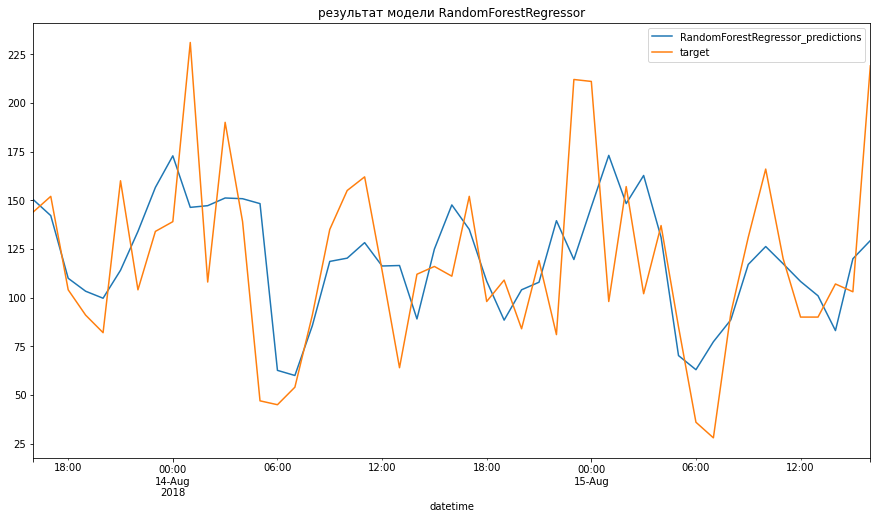

In [291]:
result_df = pd.DataFrame(data={"RandomForestRegressor_predictions":predictions['RandomForestRegressor'],
                               "GradientBoostingRegressor_predictions":predictions['GradientBoostingRegressor'],"target":  target_test})

result_df[["RandomForestRegressor_predictions","target"]]['2018-08-13 16:00:00': '2018-08-15 16:00:00'].plot(kind='line', figsize=(15,8), title='результат модели RandomForestRegressor')

<AxesSubplot:title={'center':'результат модели GradientBoostingRegressor'}, xlabel='datetime'>

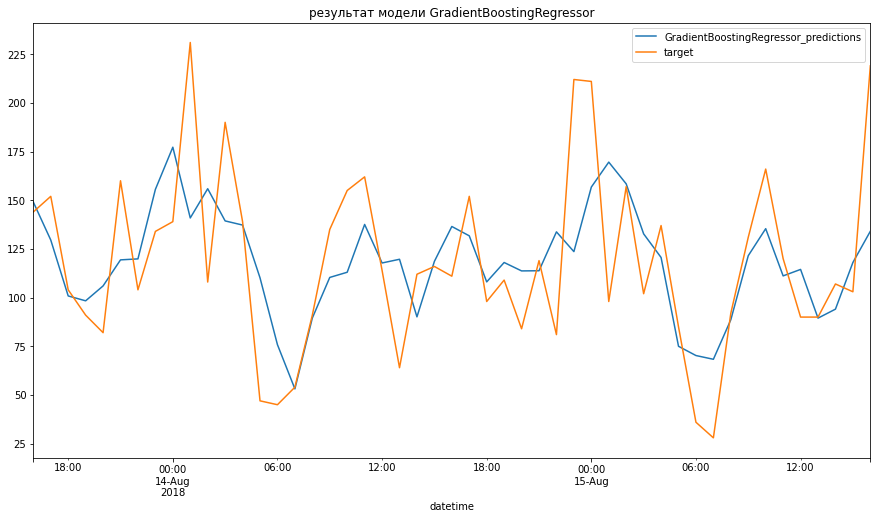

In [292]:
result_df[["GradientBoostingRegressor_predictions","target"]]['2018-08-13 16:00:00': '2018-08-15 16:00:00'].plot(kind='line', figsize=(15,8), title='результат модели GradientBoostingRegressor')

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ Полезно запомнить</b></u></p>

Разные практические истории вот здесь:<br>
1) https://ibf.org/knowledge - заморский институт бизнес-прогнозирования.<br>
Там и статьи можно накопать, и методы посмомтерть...<br>

2) Есть классический труд (он НЕ ML, а исключительно на эксель). Но для понимания сути временных рядов - то, что надо:<br>
УИЧЕРН "Бизнес-прогнозирование"<br>

3) Идеологически по системе прогнозирования, интересно почитать<br>
ТОМАС УОЛЛАС, Р. СТАЛЬ "планирование продаж и операций" SO&P<br><br>     


<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ Полезно запомнить</b></u></p>
Хотел бы оставить несколько идей для твоих будущих проектов в этой обоасти<br>

На мой взгляд, в этой теме (временные ряды) главное - необходимо чувствовать исходный ряд продаж, с точки зрения бизнеса, и уже только потом подбирать к нему модели. Каждое колебание временного ряда - это деньги для бизнеса (если говорим что заказчик бизнесовый) и за "трепетами" данных прячутся разные семейства причин. И именно знание их помогут строить хорошие прогнозы..<br>.
Леса, бустинги, регрессии.... могут подобрать хорошие модели на старых данных. Но иногда, как прогноз эти, модели могут оказаться пустышками - не интересными бизнесу. <br>  <br>
Поэтому, от себя позволю добавить несколько идей:<br>
Очень часто ищут "волшебную таблетку" или "кнопку". Нажал и само всё построилось с высокой точностью<br>
Но такого никогода не будет)))<br>
И причиной тому: модели нужно подсказать причины, по которым происходит колебания продаж (временного ряда): понимать причины колебаний треда, понимать аномалии, учитывать акционные продажи, видеть действия конкурентов , закладывать их в модель и т.д. <br><br>
В общем, всё как обычно - три группы факторов: <br>
1)внешние факторы (например выручка такси-компании зависит от количества машин на линии),<br>
2)есть факторы внутри самих данных (Вы использовали как раз поняти лаг, сезонности), <br>
3)есть параметры самих моделей (то, что обычно используется при моделировании леса или деревьев).<br><br>

Ещё важно иметь ввиду горизонт прогноза: на кокой период строить прогноз нужно  - на час вперёд, на неделю, на месяц.<br>
Это также накладывает ограничения на подбор моделей<br>
Я бы рекомендовал Вам составить для себя матрицу  в разрезе: <br>
а)есть тренд/нет тренда; <br>
б)еть сезоннотсь/нет сезонности; <br>
в)какой горизонт прогноза требуется; <br>
г) есть ли у нас дополнительные факторы для модей<br>
На пересечении знаний о моделях легко будет подобрать адкватную модель.
Не все задачи прогнозирования временных рядов можно хорошо решить лесом и еже с ним на основе знаний только факторов ряда... Они хорошо подойдут для коротких горизонтов прогнозирования.... А если горизонт чуть больше: недели, месяцы... то тут надо подключать понимания фаткоров продаж самого бизнеса.</div> 